In [1]:
import datetime as dt
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
# Access google drive spreadsheet
scope = ['https://spreadsheets.google.com/feeds',
     'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('SenseOfTouchResearch-e5927f56c4d0.json', scope)
c = gspread.authorize(credentials)
metadataSpread = c.open_by_key('1LsTdPBOW79XSkk5DJv2ckiVTvpofAOOd_dJL4cgtxBQ')
metadataFrame = pd.DataFrame(metadataSpread.sheet1.get_all_records())

In [3]:
sdc_lin_lab_start = dt.datetime(2018, 7, 23, 12, 57, 52)
sdc_in_shriram_start = dt.datetime(2018, 9, 13, 14, 19, 9)
prime95b_camera_start = dt.datetime(2018, 11, 21, 13, 17, 36)
now = dt.datetime.now()
eras = [sdc_lin_lab_start, sdc_in_shriram_start, prime95b_camera_start, now]

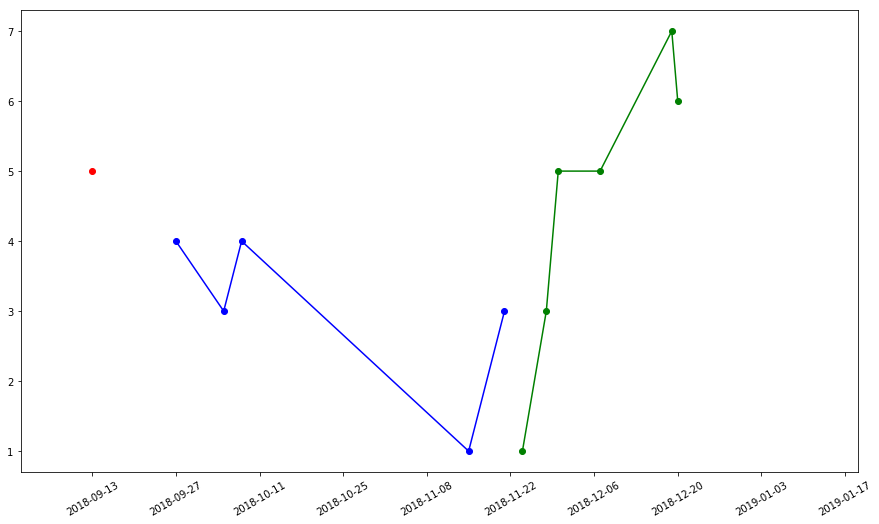

In [7]:
# helper functions
def get_worm_id(trial_id):
    worm_id = trial_id[0:7]
    
    return worm_id

def get_date(timestamp):
    this_datetime = dt.datetime.strptime(timestamp, '%m/%d/%Y %H:%M:%S')
    this_date = this_datetime.date()
    
    return this_date

# add column for worm ID
worm_id_frame = metadataFrame['Experiment ID'].apply(get_worm_id)
metadataFrame['worm id'] = worm_id_frame

# eliminate rows that have duplicate worms
metadataFrame.drop_duplicates(subset=['worm id'], inplace=True)

# add column for date
date_frame = metadataFrame['Timestamp'].apply(get_date)
metadataFrame['date'] = date_frame
# display(metadataFrame)
    
# for each date
date_list = metadataFrame['date'].tolist()
unique_dates = sorted(list(set(date_list)))
epi_scope_start_index = bisect.bisect(unique_dates, sdc_lin_lab_start.date())
num_worms = {}
worm_count = []
exp_date = []
for this_date in unique_dates:
    # get number of unique worm IDs
    this_day_worms = metadataFrame.loc[metadataFrame['date'] == this_date]
    worm_count.append(len(this_day_worms))
        
# make a plot
bar_width = 2
fig, ax = plt.subplots()
colors = ['k', 'r', 'b', 'g']
for era, color in zip(eras, colors):
    # plot everything in each setup era
    era_start_index = bisect.bisect(unique_dates, era.date())
    this_era_dates = unique_dates[0:era_start_index]
    this_era_counts = worm_count[0:era_start_index]
    for date, count in zip(this_era_dates, this_era_counts):
        unique_dates.remove(date)
        worm_count.remove(count)
    ax.plot_date(this_era_dates, this_era_counts, xdate=True, color=color, linestyle='-')

ax.xaxis_date()
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
left, right = plt.xlim() 
plt.xlim((dt.date(2018, 9, 1), right)) 
fig.set_size_inches(15, 8.5)
